In [1]:
from tensorflow.keras.applications import MobileNetV2

model = MobileNetV2(
    input_shape=(128, 128, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling="avg",
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
dataset_path = 'flowers'  # Ganti dengan path ke dataset Anda
print("Files in dataset path:", os.listdir(dataset_path))

Files in dataset path: ['bougainvillea_00056.jpg', 'bougainvillea_00052.jpg', 'bougainvillea_00077.jpg', 'bougainvillea_00055.jpg', 'daisies_00043.jpg', 'bougainvillea_00060.jpg', 'bougainvillea_00059.jpg', 'bougainvillea_00008.jpg', 'daisies_00024.jpg', 'bougainvillea_00014.jpg', 'daisies_00063.jpg', 'bougainvillea_00023.jpg', 'bougainvillea_00004.jpg', 'bougainvillea_00036.jpg', 'daisies_00027.jpg', 'daisies_00005.jpg', 'bougainvillea_00073.jpg', 'bougainvillea_00019.jpg', 'daisies_00007.jpg', 'bougainvillea_00050.jpg', 'bougainvillea_00015.jpg', 'daisies_00004.jpg', 'daisies_00054.jpg', 'bougainvillea_00040.jpg', 'daisies_00013.jpg', 'bougainvillea_00016.jpg', 'daisies_00049.jpg', 'daisies_00060.jpg', 'bougainvillea_00070.jpg', 'daisies_00032.jpg', 'daisies_00065.jpg', 'daisies_00034.jpg', 'daisies_00061.jpg', 'bougainvillea_00034.jpg', 'daisies_00051.jpg', 'bougainvillea_00043.jpg', 'bougainvillea_00042.jpg', 'daisies_00021.jpg', 'bougainvillea_00032.jpg', 'daisies_00002.jpg', 'bou

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split

# Path ke folder utama yang berisi gambar tanpa subfolder
base_dir = 'flowers'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Baca semua file gambar
image_files = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Tetapkan label berdasarkan nama file atau aturan lain
labels = []
images = []
for file_path in image_files:
    if 'lilies' in file_path:
        label = 0
    elif 'bougainvillea' in file_path:
        label = 1
    elif 'peonies' in file_path:
        label = 2
    elif 'daisies' in file_path:
        label = 3
    elif 'garden_roses' in file_path:
        label = 4
    elif 'gardenias' in file_path:
        label = 5
    elif 'hibiscus' in file_path:
        label = 6
    elif 'hydrangeas' in file_path:
        label = 7
    elif 'orchids' in file_path:
        label = 8
    elif 'peonies' in file_path:
        label = 9
    elif 'tulip' in file_path:
        label = 10
    else:
        continue  # Skip gambar jika tidak sesuai dengan label yang diinginkan

    # Load dan resize gambar
    try:
        img = load_img(file_path, target_size=IMG_SIZE)
    except OSError as e:
        print(f"Error loading image {file_path}: {e}")
        continue  # Skip gambar yang error

    img_array = img_to_array(img) / 255.0  # Normalisasi gambar
    images.append(img_array)
    labels.append(label)

# Konversi ke array numpy
images = np.array(images)
labels = np.array(labels)

# Bagi data menjadi training dan validation
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Buat generator data augmentasi
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Buat dataset dari array gambar
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=BATCH_SIZE)

# Load arsitektur MobileNetV2 tanpa lapisan klasifikasi atasnya
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freezing lapisan awal MobileNetV2

# Tambahkan lapisan atas untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(11, activation='softmax')(x)  # 11 kelas

# Buat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',  # Gunakan 'sparse_categorical_crossentropy' karena label berupa integer
              metrics=['accuracy'])

# Training model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Unfreezing beberapa lapisan dari base_model untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze hingga 100 lapisan pertama
    layer.trainable = False

# Compile ulang model untuk fine-tuning
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan training untuk fine-tuning
fine_tune_epochs = 1
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.1511 - loss: 2.5331 - val_accuracy: 0.3636 - val_loss: 2.1518
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5106 - loss: 1.9755 - val_accuracy: 0.6591 - val_loss: 1.6394
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7325 - loss: 1.3771 - val_accuracy: 0.7500 - val_loss: 1.2250
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7307 - loss: 1.0842 - val_accuracy: 0.7955 - val_loss: 0.9313
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7941 - loss: 0.8125 - val_accuracy: 0.7727 - val_loss: 0.7295
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7882 - loss: 0.6883 - val_accuracy: 0.8636 - val_loss: 0.5841
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8399 - loss: 0.5401 - val_accuracy: 0.8409 - val_loss: 0.4884
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8570 - loss: 0.4192 - val_accuracy: 0.8636 - val_loss: 0.4219
Epoch 9/20
6/6 ━━━━

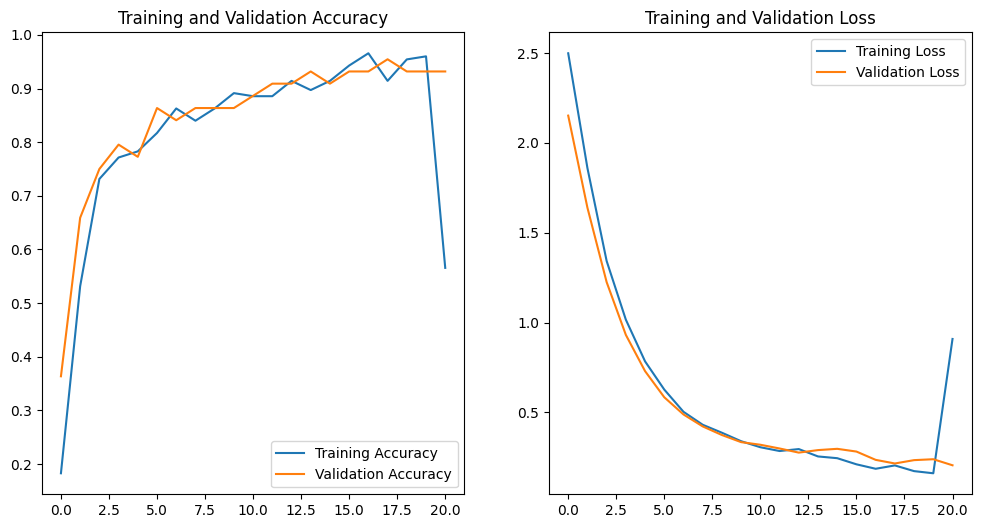

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step
Classification Report:
               precision    recall  f1-score   support

bougainvillea       1.00      0.79      0.88        14
      daisies       1.00      1.00      1.00        17
 garden_roses       0.81      1.00      0.90        13

     accuracy                           0.93        44
    macro avg       0.94      0.93      0.93        44
 weighted avg       0.94      0.93      0.93        44

Confusion Matrix:
[[11  0  3]
 [ 0 17  0]
 [ 0  0 13]]


In [9]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Menampilkan hasil training
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(EPOCHS + fine_tune_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ... (previous code) ...

# Menampilkan hasil training
# ... (code to display training results) ...

# Evaluasi model
# Instead of using val_generator.classes, use y_val directly
y_true = y_val  # y_val already contains the true labels

# Predict using the validation data (x_val)
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Updated class_labels to remove duplicate and match actual labels, include all classes
class_labels = ["lilies", "bougainvillea", "peonies", "daisies", "garden_roses", "gardenias", "hibiscus", "hydrangeas", "orchids", "tulip"]

# Get the unique classes present in y_true
unique_classes = np.unique(y_true)

# Filter class_labels to only include those present in y_true
class_labels_filtered = [class_labels[i] for i in unique_classes if i < len(class_labels)]

#  Laporan klasifikasi
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels_filtered, labels=unique_classes)) #add labels parameter to specify labels to include

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

In [40]:
from sklearn.model_selection import train_test_split

# Jika dataset kecil, gunakan train_size secara eksplisit
x_train, x_val, y_train, y_val = train_test_split(images, labels, train_size=0.7, test_size=0.3, random_state=42)

print(f"Jumlah data pelatihan: {len(x_train)}")
print(f"Jumlah data validasi: {len(x_val)}")


ValueError: With n_samples=0, test_size=0.3 and train_size=0.7, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [43]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke folder utama yang berisi gambar tanpa subfolder
base_dir = 'flowers'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Baca semua file gambar
image_files = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Tetapkan label berdasarkan nama file atau aturan lain
labels = []
images = []
for file_path in image_files:
    # Extract the class name from the file path (e.g., 'lilies' from 'flowers/lilies/00000001.jpg')
    class_name = os.path.basename(os.path.dirname(file_path)) # Get the name of the directory containing the image

    # Define a mapping of class names to numerical labels
    class_to_label = {
        "lilies": 0,
        "bougainvillea": 1,
        "peonies": 2,
        "daisies": 3,
        "garden_roses": 4,
        "gardenias": 5,
        "hibiscus": 6,
        "hydrangeas": 7,
        "orchids": 8,
        "tulip": 10  # Note: 'peonies' is already assigned to label 2
    }

    # Get the numerical label for the current image
    label = class_to_label.get(class_name)

    # If the image belongs to a known class, process it
    if label is not None:
        # Load and resize gambar
        try:
            img = load_img(file_path, target_size=IMG_SIZE)
        except OSError as e:
            print(f"Error loading image {file_path}: {e}")
            continue  # Skip gambar yang error

        img_array = img_to_array(img) / 255.0  # Normalisasi gambar
        images.append(img_array)
        labels.append(label)


In [55]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os

# Path ke folder dataset
base_dir = "flowers"  # Make sure this path is correct
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Load semua file gambar dan labelnya
image_files = [os.path.join(root, file) for root, _, files in os.walk(base_dir) for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
images = []
labels = []

# Tetapkan label berdasarkan nama folder
class_to_label = {
    "lilies": 0,
    "bougainvillea": 1,
    "peonies": 2,
    "daisies": 3,
    "garden_roses": 4,
    "gardenias": 5,
    "hibiscus": 6,
    "hydrangeas": 7,
    "orchids": 8,
    "tulip": 9
}

for file_path in image_files:
    class_name = os.path.basename(os.path.dirname(file_path))  # Nama folder adalah nama kelas

    # Check if class_name is in class_to_label keys, if not skip the file
    if class_name not in class_to_label:
        print(f"Skipping file {file_path} as class {class_name} is not in class_to_label")
        continue

    label = class_to_label.get(class_name)
    if label is not None:
        try:
            img = load_img(file_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalisasi gambar
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")  # Print errors for debugging

# Check if any images were loaded
if not images:
    print("No images loaded. Check the base_dir path and image formats.")
    # Instead of raising an exception, print the list of files found
    print("Files found in base_dir:", image_files)
    # and the current working directory
    print("Current working directory:", os.getcwd())
    # This will help you debug the issue further
    # Exit the script if no images were loaded to prevent further errors
    import sys
    sys.exit(1) # Exit with a non-zero status code to indicate an error


# Konversi ke array numpy
images = np.array(images)
labels = np.array(labels)

# ... (rest of your code remains the same) ...
# Split data menjadi training dan testing (70% training, 30% testing)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(class_to_label))
y_test = to_categorical(y_test, num_classes=len(class_to_label))

# ... (rest of the code remains the same) ...


# Load MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(len(class_to_label), activation="softmax")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Evaluate the model
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
target_names = list(class_to_label.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)


SyntaxError: '(' was never closed (<ipython-input-55-d09c2744f24b>, line 74)

In [27]:
import os

# Periksa apakah direktori dataset ada
base_dir = 'flowers'  # Jalur dataset
if os.path.exists(base_dir):
    print(f"Dataset directory found: {base_dir}")
    print("Classes:", os.listdir(base_dir))  # Daftar sub-folder kelas
else:
    print("Dataset directory not found. Check the path!")


Dataset directory found: flowers
Classes: ['tulip_00065.jpg', 'lilies_00073.jpg', 'hibiscus_00025.jpg', 'orchids_00045.jpg', 'orchids_00036.jpg', 'gardenias_00063.jpg', 'garden_roses_00009.jpg', 'bougainvillea_00056.jpg', 'bougainvillea_00052.jpg', 'daisies_00081.jpg', 'orchids_00031.jpg', 'hydrangeas_00045.jpg', 'hydrangeas_00015.jpg', 'gardenias_00064.jpg', 'tulip_00075.jpg', 'hibiscus_00027.jpg', 'lilies_00080.jpg', 'lilies_00083.jpg', 'hydrangeas_00028.jpg', 'orchids_00039.jpg', 'garden_roses_00051.jpg', 'bougainvillea_00077.jpg', 'bougainvillea_00055.jpg', 'daisies_00043.jpg', 'bougainvillea_00060.jpg', 'orchids_00034.jpg', 'hydrangeas_00043.jpg', 'orchids_00042.jpg', 'orchids_00046.jpg', 'bougainvillea_00059.jpg', 'daisies_00075.jpg', 'gardenias_00010.jpg', 'hibiscus_00064.jpg', 'orchids_00003.jpg', 'peonies_00051.jpg', 'bougainvillea_00008.jpg', 'garden_roses_00068.jpg', 'orchids_00024.jpg', 'tulip_00057.jpg', 'orchids_00016.jpg', 'gardenias_00035.jpg', 'orchids_00032.jpg', 'dai

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

# Path ke folder dataset
dataset_dir = "flowers"

# Parameter model
input_shape = (224, 224, 3)
batch_size = 32

# Data Augmentation dan Load Dataset
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2  # 20% data untuk uji
)

# Data Pelatihan
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

# Data Validasi
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

# Data Uji
test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False  # Tetap agar indeks hasil evaluasi konsisten
)

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


# Fine-tuning: Recreate the model after unfreezing layers
base_model.trainable = True
fine_tune_at = 100  # Unfreeze all layers after this index

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recreate the model to incorporate the changes
x = base_model.output # Reconnect the output after making layers trainable
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions) # Recreate the model

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs
)

# Visualize training results
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate on test data
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
class_labels = list(train_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


ValueError: Must provide at least one structure

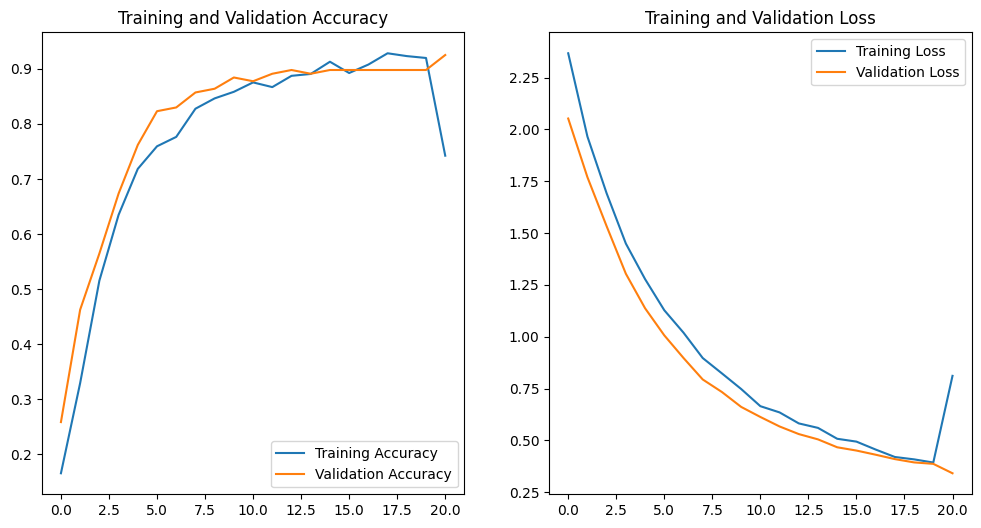

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Classification Report:
               precision    recall  f1-score   support

       lilies       0.00      0.00      0.00        19
bougainvillea       0.10      1.00      0.19        15
      peonies       0.00      0.00      0.00        20
      daisies       0.00      0.00      0.00        12
 garden_roses       0.00      0.00      0.00        10
    gardenias       0.00      0.00      0.00        17
     hibiscus       0.00      0.00      0.00        13
   hydrangeas       0.00      0.00      0.00        13
      orchids       0.00      0.00      0.00         8
        tulip       0.00      0.00      0.00        20

     accuracy                           0.10       147
    macro avg       0.01      0.10      0.02       147
 weighted avg       0.01      0.10      0.02       147

Confusion Matrix:
[[ 0 19  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# Bagi data menjadi training dan validation
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# Menampilkan hasil training
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(EPOCHS + fine_tune_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ... (previous code) ...

# Menampilkan hasil training
# ... (code to display training results) ...

val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_true and y_pred_classes have the same length
y_true = y_val[:len(y_pred_classes)]  # Trim y_true to match y_pred_classes length

# Updated class_labels to remove duplicate and match actual labels
class_labels = ["lilies", "bougainvillea", "peonies", "daisies", "garden_roses", "gardenias", "hibiscus", "hydrangeas", "orchids", "tulip"]

#  Laporan klasifikasi
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))


In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:

# Path ke folder utama yang berisi gambar tanpa subfolder
base_dir = 'flowers'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Baca semua file gambar
image_files = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]


In [ ]:
# Tetapkan label berdasarkan nama file atau aturan lain
labels = []
images = []
for file_path in image_files:
    if 'lilies' in file_path:
        label = 0
    elif 'bougainvillea' in file_path:
        label = 1
    elif 'peonies' in file_path:
        label = 2
    elif 'daisies' in file_path:
        label = 3
    elif 'garden_roses' in file_path:
        label = 4
    elif 'gardenias' in file_path:
        label = 5
    elif 'hibiscus' in file_path:
        label = 6
    elif 'hydrangeas' in file_path:
        label = 7
    elif 'orchids' in file_path:
        label = 8
    elif 'tulip' in file_path:
        label = 9
    else:
        continue  # Skip gambar jika tidak sesuai dengan label yang diinginkan

        # Load dan resize gambar
    img = load_img(file_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalisasi gambar
    images.append(img_array)
    labels.append(label)

# Konversi ke array numpy
images = np.array(images)
labels = np.array(labels)

In [ ]:
# Bagi data menjadi training dan validation
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
# Buat generator data augmentasi
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Buat dataset dari array gambar
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=BATCH_SIZE)

# Load arsitektur MobileNetV2 tanpa lapisan klasifikasi atasnya
base_model = DenseNet169(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freezing lapisan awal MobileNetV2


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Tambahkan lapisan atas untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)  # 10 kelas

# Buat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',  # Gunakan 'sparse_categorical_crossentropy' karena label berupa integer
              metrics=['accuracy'])

# Training model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)
# Unfreezing beberapa lapisan dari base_model untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:250]:  # Freeze hingga 100 lapisan pertama
    layer.trainable = False

# Compile ulang model untuk fine-tuning
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan training untuk fine-tuning
fine_tune_epochs = 1
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - accuracy: 0.1548 - loss: 2.4661 - val_accuracy: 0.2585 - val_loss: 2.0526
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 191s 8s/step - accuracy: 0.2789 - loss: 2.0506 - val_accuracy: 0.4626 - val_loss: 1.7697
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 161s 8s/step - accuracy: 0.4970 - loss: 1.7279 - val_accuracy: 0.5646 - val_loss: 1.5331
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 161s 8s/step - accuracy: 0.6509 - loss: 1.4579 - val_accuracy: 0.6735 - val_loss: 1.3040
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 160s 8s/step - accuracy: 0.7294 - loss: 1.3048 - val_accuracy: 0.7619 - val_loss: 1.1375
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 159s 8s/step - accuracy: 0.7949 - loss: 1.0910 - val_accuracy: 0.8231 - val_loss: 1.0068
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 201s 8s/step - accuracy: 0.7689 - loss: 1.0481 - val_accuracy: 0.8299 - val_loss: 0.8977
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 159s 8s/step - accuracy: 0.8162 - loss: 0.9237 - val_accuracy: 0.8571 - val_loss: 0.

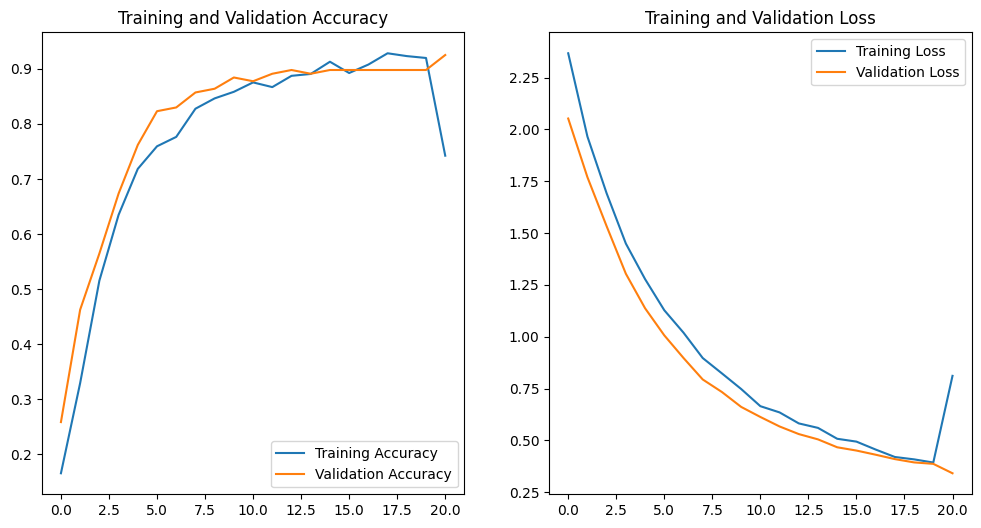

5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step


In [ ]:
# Menampilkan hasil training
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(EPOCHS + fine_tune_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_val
class_labels = ["lilies", "bougainvillea", "peonies", "daisies", "garden_roses", "gardenias", "hibiscus", "hydrangeas", "orchids", "tulip"]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik utama
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Tampilkan metrik
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matriks kebingungan
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.08
Precision: 0.08
Recall: 0.08
F1 Score: 0.08

Classification Report:
               precision    recall  f1-score   support

       lilies       0.10      0.11      0.10        19
bougainvillea       0.29      0.27      0.28        15
      peonies       0.00      0.00      0.00        20
      daisies       0.00      0.00      0.00        12
 garden_roses       0.08      0.10      0.09        10
    gardenias       0.00      0.00      0.00        17
     hibiscus       0.09      0.08      0.08        13
   hydrangeas       0.13      0.15      0.14        13
      orchids       0.11      0.12      0.12         8
        tulip       0.05      0.05      0.05        20

     accuracy                           0.08       147
    macro avg       0.08      0.09      0.09       147
 weighted avg       0.08      0.08      0.08       147



NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 Score: 0.02

Classification Report:
               precision    recall  f1-score   support

       lilies       0.00      0.00      0.00        19
bougainvillea       0.10      1.00      0.19        15
      peonies       0.00      0.00      0.00        20
      daisies       0.00      0.00      0.00        12
 garden_roses       0.00      0.00      0.00        10
    gardenias       0.00      0.00      0.00        17
     hibiscus       0.00      0.00      0.00        13
   hydrangeas       0.00      0.00      0.00        13
      orchids       0.00      0.00      0.00         8
        tulip       0.00      0.00      0.00        20

     accuracy                           0.10       147
    macro avg       0.01      0.10      0.02       147
 weighted avg       0.01      0.10      0.02       147



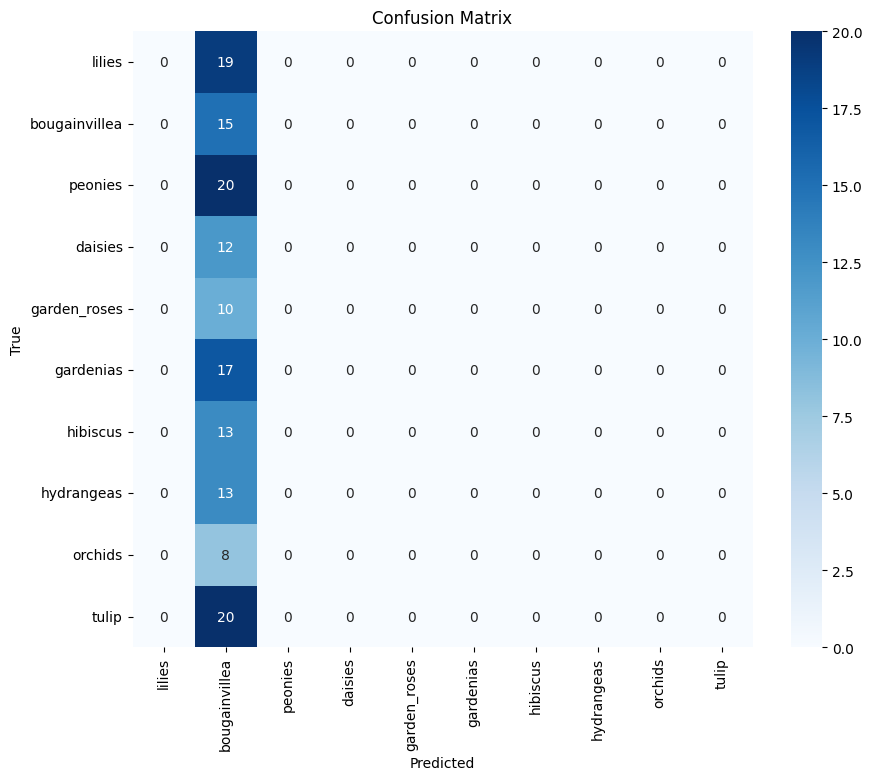

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik utama
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Tampilkan metrik
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matriks kebingungan
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Path ke folder utama yang berisi gambar tanpa subfolder
base_dir = 'flowers'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001



In [ ]:
# Baca semua file gambar
image_files = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Tetapkan label berdasarkan nama file atau aturan lain
labels = []
images = []
for file_path in image_files:
    if 'lilies' in file_path:
        label = 0
    elif 'bougainvillea' in file_path:
        label = 1
    elif 'peonies' in file_path:
        label = 2
    elif 'daisies' in file_path:
        label = 3
    elif 'garden_roses' in file_path:
        label = 4
    elif 'gardenias' in file_path:
        label = 5
    elif 'hibiscus' in file_path:
        label = 6
    elif 'hydrangeas' in file_path:
        label = 7
    elif 'orchids' in file_path:
        label = 8
    elif 'tulip' in file_path:
        label = 9
    else:
        continue  # Skip gambar jika tidak sesuai dengan label yang diinginkan


In [ ]:
    # Load dan resize gambar
    img = load_img(file_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalisasi gambar
    images.append(img_array)
    labels.append(label)

# Konversi ke array numpy
images = np.array(images)
labels = np.array(labels)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Path ke folder utama yang berisi gambar tanpa subfolder
base_dir = 'flowers' # Make sure this path is correct
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Baca semua file gambar
image_files = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Tetapkan label berdasarkan nama file atau aturan lain
labels = []
images = []
for file_path in image_files:
    # Assuming folder names are the labels
    label = os.path.basename(os.path.dirname(file_path))

    # Create a numerical label based on unique label names
    if label not in class_labels:
        class_labels.append(label)
    label_index = class_labels.index(label)

    # Load and resize gambar
    img = load_img(file_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalisasi gambar
    images.append(img_array)
    labels.append(label_index) #Append the numerical label

# Konversi ke array numpy
images = np.array(images)
labels = np.array(labels)

# Bagi data menjadi training dan validation
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42) #This should work now with sufficient samples

In [ ]:

# Buat generator data augmentasi
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Buat dataset dari array gambar
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=BATCH_SIZE)

# Load arsitektur MobileNetV2 tanpa lapisan klasifikasi atasnya
base_model = EfficientNetV2B0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freezing lapisan awal MobileNetV2


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Tambahkan lapisan atas untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)  # 10 kelas

# Buat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',  # Gunakan 'sparse_categorical_crossentropy' karena label berupa integer
              metrics=['accuracy'])


In [ ]:
# Training model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Unfreezing beberapa lapisan dari base_model untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:200]:  # Freeze hingga 100 lapisan pertama
    layer.trainable = False

# Compile ulang model untuk fine-tuning
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan training untuk fine-tuning
fine_tune_epochs = 1
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator
)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-30-1ce2c3e3fba9>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 359, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 327, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 611, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 652, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 1870, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1559, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 10 which is outside the valid range of [0, 10).  Label values: 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_185180]

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 Score: 0.02

Classification Report:
               precision    recall  f1-score   support

 garden_roses       0.00      0.00      0.00        19
bougainvillea       0.10      1.00      0.19        15
      daisies       0.00      0.00      0.00        20
       lilies       0.00      0.00      0.00        12
    gardenias       0.00      0.00      0.00        10
     hibiscus       0.00      0.00      0.00        17
   hydrangeas       0.00      0.00      0.00        13
      orchids       0.00      0.00      0.00        13
        tulip       0.00      0.00      0.00         8
      peonies       0.00      0.00      0.00        20

     accuracy                           0.10       147
    macro avg       0.01      0.10      0.02       147
 weighted avg       0.01      0.10      0.02       147


Confusion Matrix:
[[ 0 19  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0 

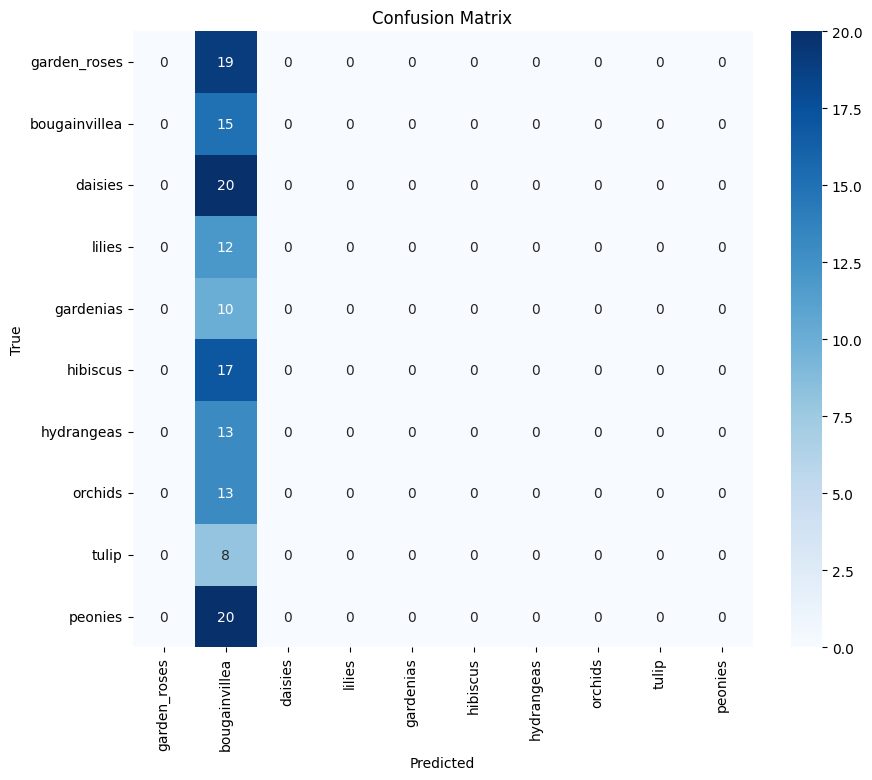

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Prediksi pada data validasi
y_pred_probs = model.predict(x_val)  # Menghasilkan probabilitas prediksi
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Konversi ke kelas prediksi
y_true = y_val  # Ground truth dari data validasi

# Hitung metrik utama
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Tampilkan metrik utama
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Laporan klasifikasi
class_labels = list(set(class_labels))  # Pastikan class_labels sudah terisi
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matriks kebingungan
cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Visualisasi matriks kebingungan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 Score: 0.02

Classification Report:
               precision    recall  f1-score   support

 garden_roses       0.00      0.00      0.00        24
bougainvillea       0.10      1.00      0.17        21
      daisies       0.00      0.00      0.00        26
       lilies       0.00      0.00      0.00        24
    gardenias       0.00      0.00      0.00        20
     hibiscus       0.00      0.00      0.00        23
   hydrangeas       0.00      0.00      0.00        18
      orchids       0.00      0.00      0.00        17
        tulip       0.00      0.00      0.00        19
      peonies       0.00      0.00      0.00        28

     accuracy                           0.10       220
    macro avg       0.01      0.10      0.02       220
 weighted avg       0.01      0.10      0.02       220


Confusion Matrix:
[[ 0 24  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0 

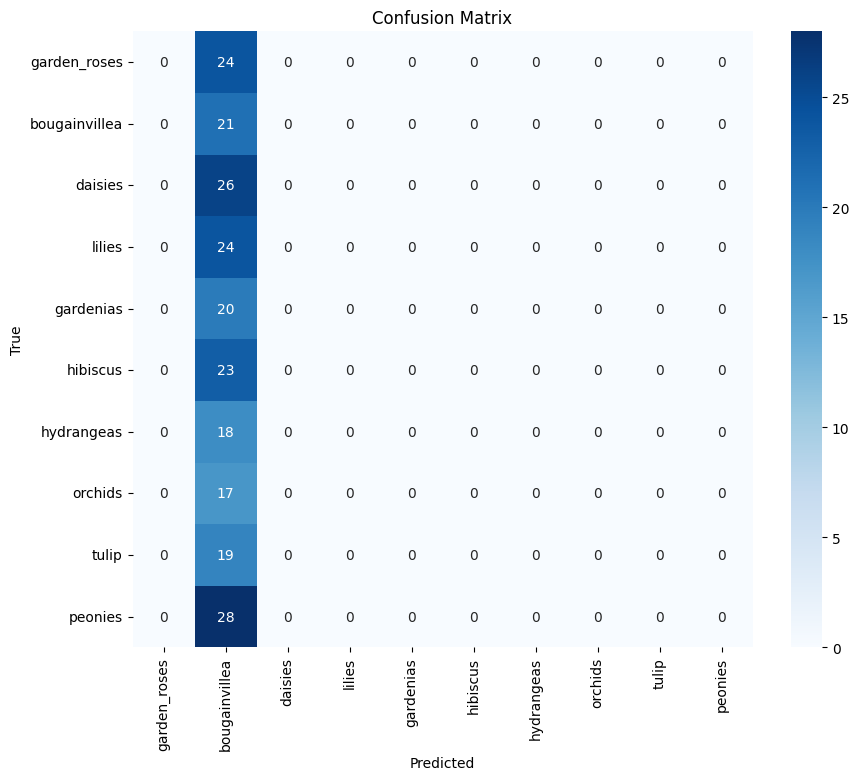

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# Prediksi pada data validasi
y_pred_probs = model.predict(x_val)  # Menghasilkan probabilitas prediksi
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Konversi ke kelas prediksi
y_true = y_val  # Ground truth dari data validasi

# Hitung metrik utama
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Tampilkan metrik utama
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Laporan klasifikasi
class_labels = list(set(class_labels))  # Pastikan class_labels sudah terisi
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matriks kebingungan
cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Visualisasi matriks kebingungan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
